In [1]:
#!ipcluster start -n 8 --engines=MPI --profile='mpi' # for parallel run: start the engines using terminal
from ipyparallel import Client
rc = Client(profile='mpi')

In [2]:
%%px
# Import the libraries

import os
import sys
import math
import pyJHTDB
import numpy as np
import pyfftw as ft 
from mpi4py import MPI
from pyJHTDB import libJHTDB
from pyJHTDB.dbinfo import isotropic1024coarse

from mpiFFT4py.slab import R2C

In [3]:
%%px

Nx = isotropic1024coarse['nx']; Ny = isotropic1024coarse['ny']; Nz = isotropic1024coarse['nz']
Lx = isotropic1024coarse['lx']; Ly = isotropic1024coarse['ly']; Lz = isotropic1024coarse['lz']
nu = isotropic1024coarse['nu']

comm = MPI.COMM_WORLD; rank = comm.Get_rank(); nproc = comm.Get_size()
if(rank==0):
    print("n_proc = "+str(nproc))
    print("rank = "+str(rank))

nx=Nx//nproc; ny=Ny; nz=Nz; nz_half=nz//2
nek=int(math.sqrt(2.0)/3*Nx); time = 0.0 

chkSz = 32; slabs = nx//chkSz

[stdout:6] 
n_proc = 8
rank = 0


In [4]:
%%px 

N = np.array([Nx,Ny,Nz],dtype=int)
L = np.array([Lx,Ly,Lz],dtype=float)

FFT = R2C(N, L, MPI.COMM_WORLD, "double", communication='Alltoallw')

In [5]:
%%px

if(rank==0):
    print(FFT.real_shape())
    print(FFT.complex_shape())

[stdout:6] 
(128, 1024, 1024)
(1024, 128, 513)


In [6]:
%%px

from DataDownload import DataDownload

# Populate velocity field from the Database

if(rank==0):
    print("Starting the loading process")

##########################################
load_from_file = True
store_on_file = False
auth_token = "com.gmail.jhelsas-b854269a"

folder = "/home/admin/scratch"
filename = "ref-isotropic1024coarse-"+str(rank)+"-(t="+str(time)+")"+".npz"
file = folder + "/" + filename

vx = np.zeros(FFT.real_shape(), dtype=FFT.float)
vy = np.zeros(FFT.real_shape(), dtype=FFT.float)
vz = np.zeros(FFT.real_shape(), dtype=FFT.float)
    
if(load_from_file):
    comm.Barrier(); t1=MPI.Wtime()
    content = np.load(file)
    if(int(content['nproc'])!=nproc):
        print("Unmatched number of processes. Must first pre-process to adequate number of process")
        
    vx[:,:,:] = content['vx'].astype(FFT.float)
    vy[:,:,:] = content['vy'].astype(FFT.float)
    vz[:,:,:] = content['vz'].astype(FFT.float)
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        print("Finished loading")
        sys.stdout.write('Load from disk: {0:.2f} seconds\n'.format(t2-t1))
else:
    comm.Barrier(); t1=MPI.Wtime()
    
    ddwnld = DataDownload()
    vxd,vyd,vzd = ddwnld.DownldData_pyJHTDB('isotropic1024coarse',time,nx,ny,nz,nproc,rank,auth_token)
    
    vx[:,:,:] = vxd.astype(FFT.float)
    vy[:,:,:] = vyd.astype(FFT.float)
    vz[:,:,:] = vzd.astype(FFT.float)
    
    del vxd,vyd,vzd
    
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        print("Finished loading")
        sys.stdout.write('Load field from database: {0:.2f} seconds\n'.format(t2-t1))
    
    comm.Barrier(); t1=MPI.Wtime()
    
    np.savez(file,vx=vx,vy=vy,vz=vz,nproc=nproc)
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        sys.stdout.write('Caching the data: {0:.2f} seconds\n'.format(t2-t1))


if(rank==0):
    print("vx shape = "+str(vx.shape))       

[stdout:6] 
Starting the loading process
Finished loading
Load from disk: 6.53 seconds
vx shape = (128, 1024, 1024)


In [7]:
%%px
comm.Barrier(); t1=MPI.Wtime()

K = 0.5*(vx**2+vy**2+vz**2)

slabK = np.sum(K)

avgK=np.zeros(1,dtype=FFT.float)

comm.Reduce([slabK,MPI.DOUBLE],[avgK,MPI.DOUBLE],op=MPI.SUM)
avgK = avgK[0]*(1024**(-3))
avgK = comm.bcast(avgK, root=0)

comm.Barrier(); t2=MPI.Wtime()
if rank==0:
    print("kinectic energy = "+str(avgK))
    print("Computing kinectic energy: ", t2-t1,"s")

[stdout:6] 
kinectic energy = 0.682719227202
('Computing kinectic energy: ', 3.983412027359009, 's')


In [8]:
%%px
comm.Barrier(); t1=MPI.Wtime()

kx,ky,kz = FFT.get_local_wavenumbermesh()
k2 = kx**2 + ky**2 + kz**2

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    print("Computing wavenumbers:",t2-t1)

[stdout:6] ('Computing wavenumbers:', 1.7044200897216797)


In [9]:
%%px 
comm.Barrier(); t1=MPI.Wtime()

cvx = np.zeros(FFT.complex_shape(), dtype=FFT.complex)
cvy = np.zeros(FFT.complex_shape(), dtype=FFT.complex)
cvz = np.zeros(FFT.complex_shape(), dtype=FFT.complex)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Preparing FFT: {0:.2f} seconds\n'.format(t2-t1))

[stdout:6] Preparing FFT: 0.00 seconds


In [10]:
%%px
comm.Barrier(); t1=MPI.Wtime()

cvx = FFT.fftn(vx,cvx)
cvy = FFT.fftn(vy,cvy)
cvz = FFT.fftn(vz,cvz)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate 3D spatial FFT: {0:.2f} seconds\n'.format(t2-t1))

[stdout:6] Calculate 3D spatial FFT: 45.67 seconds


In [11]:
%%px
comm.Barrier(); t1=MPI.Wtime()

cA = np.zeros(FFT.complex_shape(), dtype=FFT.complex)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('alocating fourier space derivatives: {0:.2f} seconds\n'.format(t2-t1))

[stdout:6] alocating fourier space derivatives: 0.00 seconds


In [12]:
%%px
comm.Barrier(); t1=MPI.Wtime()

A11 = np.zeros(FFT.real_shape(), dtype=FFT.float)
A12 = np.zeros(FFT.real_shape(), dtype=FFT.float)
A13 = np.zeros(FFT.real_shape(), dtype=FFT.float)
A21 = np.zeros(FFT.real_shape(), dtype=FFT.float)
A22 = np.zeros(FFT.real_shape(), dtype=FFT.float)
A23 = np.zeros(FFT.real_shape(), dtype=FFT.float)
A31 = np.zeros(FFT.real_shape(), dtype=FFT.float)
A32 = np.zeros(FFT.real_shape(), dtype=FFT.float)
A33 = np.zeros(FFT.real_shape(), dtype=FFT.float)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Alocate real space gradients: {0:.2f} seconds\n'.format(t2-t1))

[stdout:6] Alocate real space gradients: 0.00 seconds


In [13]:
%%px
comm.Barrier(); t1=MPI.Wtime()
 
cA[:,:,:] = np.complex64(0.0+1.0j)*kx[:,:,:]*cvx[:,:,:]
A11 = FFT.ifftn(cA,A11)
A11[:,:,:] = A11[:,:,:]

cA[:,:,:] = np.complex64(0.0+1.0j)*kx[:,:,:]*cvy[:,:,:]
A12 = FFT.ifftn(cA,A12)
A12[:,:,:] = A12[:,:,:]

cA[:,:,:] = np.complex64(0.0+1.0j)*kx[:,:,:]*cvz[:,:,:]
A13 = FFT.ifftn(cA,A13)
A13[:,:,:] = A13[:,:,:]

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate velocity gradient in wavenumber space, and FFT back: {0:.2f} seconds\n'.format(t2-t1))

[stdout:6] Calculate velocity gradient in wavenumber space, and FFT back: 59.18 seconds


In [14]:
%%px
comm.Barrier(); t1=MPI.Wtime()
 
cA[:,:,:] = np.complex64(0.0+1.0j)*ky[:,:,:]*cvx[:,:,:]
A21 = FFT.ifftn(cA,A21)
A21[:,:,:] = A21[:,:,:]

cA[:,:,:] = np.complex64(0.0+1.0j)*ky[:,:,:]*cvy[:,:,:]
A22 = FFT.ifftn(cA,A22)
A22[:,:,:] = A22[:,:,:]

cA[:,:,:] = np.complex64(0.0+1.0j)*ky[:,:,:]*cvz[:,:,:]
A23 = FFT.ifftn(cA,A23)
A23[:,:,:] = A23[:,:,:]

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate velocity gradient in wavenumber space: {0:.2f} seconds\n'.format(t2-t1))

[stdout:6] Calculate velocity gradient in wavenumber space: 46.01 seconds


In [15]:
%%px
comm.Barrier(); t1=MPI.Wtime()
 
cA[:,:,:] = np.complex64(0.0+1.0j)*kz[:,:,:]*cvx[:,:,:]
A31 = FFT.ifftn(cA,A31)
A31[:,:,:] = A31[:,:,:]

cA[:,:,:] = np.complex64(0.0+1.0j)*kz[:,:,:]*cvy[:,:,:]
A32 = FFT.ifftn(cA,A32)
A32[:,:,:] = A32[:,:,:]

cA[:,:,:] = np.complex64(0.0+1.0j)*kz[:,:,:]*cvz[:,:,:]
A33 = FFT.ifftn(cA,A33)
A33[:,:,:] = A33[:,:,:]

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate velocity gradient in wavenumber space: {0:.2f} seconds\n'.format(t2-t1))

[stdout:6] Calculate velocity gradient in wavenumber space: 46.41 seconds


In [16]:
%%px

del cA

In [17]:
%%px

del cvx,cvy,cvz

In [18]:
%%px 

A  = [A11,A12,A13,A21,A22,A23,A31,A32,A33]
la = ['A11','A12','A13','A21','A22','A23','A31','A32','A33']

for i in range(9):
    Aav = np.average(A[i])
    slabAavg = np.sum(Aav)
    
    avgA =np.zeros(1,dtype=FFT.float)
    
    comm.Reduce([slabAavg,MPI.DOUBLE],[avgA,MPI.DOUBLE],op=MPI.SUM)
    avgA = avgA[0]/nproc #avgK[0]*(1024**(-3))
    avgA = comm.bcast(avgA, root=0)
    
    if rank==0:
        print("<"+la[i]+"> = "+str(avgA))

[stdout:6] 
<A11> = -1.30098966742e-19
<A12> = 5.55111512313e-17
<A13> = 1.38777878078e-17
<A21> = -1.01686305318e-18
<A22> = -1.80841534239e-19
<A23> = 3.52471585176e-19
<A31> = -9.69798957866e-20
<A32> = -1.0412797705e-19
<A33> = -2.38926984033e-20


In [19]:
%%px 

A  = [A11,A12,A13,A21,A22,A23,A31,A32,A33]
la = ['A11','A12','A13','A21','A22','A23','A31','A32','A33']

for i in range(9):
    A2av = np.average(A[i]**2)
    
    avgA2 =np.zeros(1,dtype=FFT.float)
    
    comm.Reduce([A2av,MPI.DOUBLE],[avgA2,MPI.DOUBLE],op=MPI.SUM)
    avgA2 = avgA2[0]/nproc #avgK[0]*(1024**(-3))
    avgA2 = comm.bcast(avgA2, root=0)
    
    if rank==0:
        print("<"+la[i]+"^2> = "+str(avgA2))

[stdout:6] 
<A11^2> = 33.2611325939
<A12^2> = 66.9627075507
<A13^2> = 67.0288607655
<A21^2> = 65.7716675104
<A22^2> = 33.0683197566
<A23^2> = 65.7397872063
<A31^2> = 66.6281516672
<A32^2> = 66.7571668279
<A33^2> = 33.2177134126


In [20]:
%%px 

A  = [A11,A12,A13,A21,A22,A23,A31,A32,A33]
la = ['A11','A12','A13','A21','A22','A23','A31','A32','A33']

for i in range(9):  
    A2 = A[i]**2
    A2av = np.sum(A2, dtype=FFT.float)
    avgA2 =np.zeros(1,dtype=FFT.float)
    comm.Reduce([A2av,MPI.DOUBLE],[avgA2,MPI.DOUBLE],op=MPI.SUM)
    avgA2 = avgA2[0]/(Nx*Ny*Nz) 
    avgA2 = comm.bcast(avgA2, root=0)
    
    if rank==0:
        print("<"+la[i]+"^2> = "+str(avgA2))
        
    A3 = A[i]/np.sqrt(avgA2)
    A3 = A3**3
    A3av = np.sum(A3, dtype=FFT.float)    
    avgA3 = np.zeros(1,dtype=FFT.float)    
    comm.Reduce([A3av,MPI.DOUBLE],[avgA3,MPI.DOUBLE],op=MPI.SUM)    
    avgA3 = avgA3[0]/(Nx*Ny*Nz) 
    avgA3 = comm.bcast(avgA3, root=0)
    
    skewness = avgA3#/(avgA2**(3/2))
    
    if rank==0:
        print("skewness = <"+la[i]+"^3>/"+"<"+la[i]+"^2>^(3/2) "+"= "+str(skewness) )
        print("\n")

[stdout:6] 
<A11^2> = 33.2611325939
skewness = <A11^3>/<A11^2>^(3/2) = -0.590255397263


<A12^2> = 66.9627075507
skewness = <A12^3>/<A12^2>^(3/2) = -0.0262069345797


<A13^2> = 67.0288607655
skewness = <A13^3>/<A13^2>^(3/2) = -0.044600022822


<A21^2> = 65.7716675104
skewness = <A21^3>/<A21^2>^(3/2) = -0.00580459082167


<A22^2> = 33.0683197566
skewness = <A22^3>/<A22^2>^(3/2) = -0.553907679429


<A23^2> = 65.7397872063
skewness = <A23^3>/<A23^2>^(3/2) = -0.0494113131351


<A31^2> = 66.6281516672
skewness = <A31^3>/<A31^2>^(3/2) = 0.00386564467191


<A32^2> = 66.7571668279
skewness = <A32^3>/<A32^2>^(3/2) = 0.00726917637397


<A33^2> = 33.2177134126
skewness = <A33^3>/<A33^2>^(3/2) = -0.576321276815




In [21]:
%%px 

div = A11+A22+A33 

div2av = np.average(div**2)
    
avgdiv2 =np.zeros(1,dtype=FFT.float)
   
comm.Reduce([div2av,MPI.DOUBLE],[avgdiv2,MPI.DOUBLE],op=MPI.SUM)
avgdiv2 = avgdiv2[0]/nproc 
avgdiv2 = comm.bcast(avgdiv2, root=0)

if rank==0:
    print("<(div v)^2> = "+str(avgdiv2))

[stdout:6] <(div v)^2> = 3.28650680121e-09


In [22]:
%%px

vx_xlp = vx[:,0,0]

vx_xl = comm.gather(vx_xlp,root=0)
if rank==0:
    l = tuple(vx_xl)
    vx_xl = np.concatenate(l)

vx_yl = vx[0,:,0]
vx_zl = vx[0,0,:]

##########################

vy_xlp = vy[:,0,0]

vy_xl = comm.gather(vy_xlp,root=0)
if rank==0:
    l = tuple(vy_xl)
    vy_xl = np.concatenate(l)

vy_yl = vy[0,:,0]
vy_zl = vy[0,0,:]

##########################

vz_xlp = vz[:,0,0]

vz_xl = comm.gather(vz_xlp,root=0)
if rank==0:
    l = tuple(vz_xl)
    vz_xl = np.concatenate(l)

vz_yl = vz[0,:,0]
vz_zl = vz[0,0,:]

if rank==0:
    print(vx_xl.shape)
    print(vx_yl.shape)
    print(vx_zl.shape)

[stdout:6] 
(1024,)
(1024,)
(1024,)


In [23]:
%%px

vx_xlpdx = A11[:,0,0]

vx_xldx = comm.gather(vx_xlpdx,root=0)
if rank==0:
    ldx = tuple(vx_xldx)
    vx_xldx = np.concatenate(ldx)

vx_yldx = A21[0,:,0]
vx_zldx = A31[0,0,:]

########################

vy_xlpdx = A12[:,0,0]

vy_xldx = comm.gather(vy_xlpdx,root=0)
if rank==0:
    ldy = tuple(vy_xldx)
    vy_xldx = np.concatenate(ldy)

vy_yldx = A22[0,:,0]
vy_zldx = A32[0,0,:]

########################


vz_xlpdx = A13[:,0,0]

vz_xldx = comm.gather(vz_xlpdx,root=0)
if rank==0:
    ldz = tuple(vz_xldx)
    vz_xldx = np.concatenate(ldz)

vz_yldx = A23[0,:,0]
vz_zldx = A33[0,0,:]

[stdout:0] (1024,)
[stdout:1] (1024,)
[stdout:2] (1024,)
[stdout:3] (1024,)
[stdout:4] (1024,)
[stdout:5] (1024,)
[stdout:6] (1024,)
[stdout:7] (1024,)


[output:6]

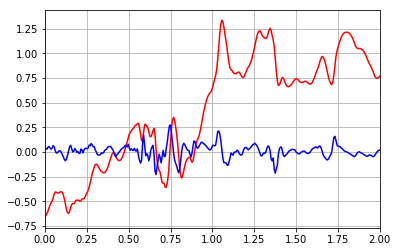

In [24]:
%%px
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

Y = np.linspace(0,2.*np.pi,Ny)
print(Y.shape)

if rank==0:
    plt.plot(Y,vx_xl,'r-')
    plt.plot(Y,vx_xldx/100,'b-')
    plt.grid()
    
    plt.xlim((0,2))
    
    plt.show()

[output:6]

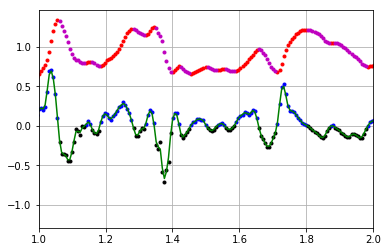

In [25]:
%%px 

if rank==0:
    pos = vx_xldx > 0
    neg = vx_xldx < 0
    scale = 30
    
    dx = 2.*np.pi/1024
    vlgrx = np.gradient(vx_xl)/dx
    
    plt.plot(Y[pos],vx_xl[pos],'r.')
    plt.plot(Y[pos],vx_xldx[pos]/scale,'b.')
    
    plt.plot(Y[neg],vx_xl[neg],'m.')
    plt.plot(Y[neg],vx_xldx[neg]/scale,'k.')
    
    plt.plot(Y,vlgrx/scale,'g')
    plt.grid()
    
    plt.xlim((1,2))
    
    plt.show()

[output:6]

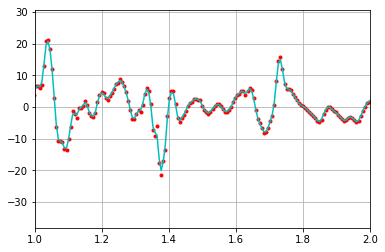

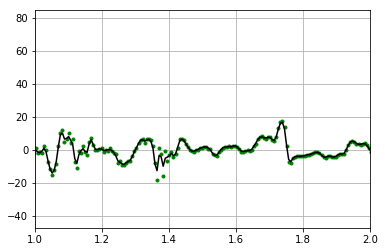

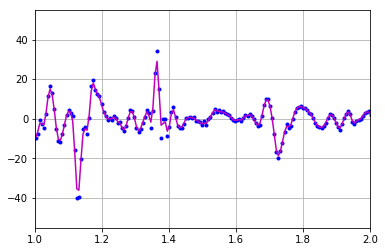

In [26]:
%%px 

if rank==0:
    pos = vx_xldx > 0
    neg = vx_xldx < 0
    scale = 30
    
    dx = 2.*np.pi/1024
    vxlgrx = np.gradient(vx_xl)/dx
    vylgrx = np.gradient(vy_xl)/dx
    vzlgrx = np.gradient(vz_xl)/dx
            
    plt.xlim((1,2))
    plt.grid()
    plt.plot(Y,vx_xldx,'r.')
    plt.plot(Y,vxlgrx,'c-')
    
    plt.show()
    
    plt.xlim((1,2))
    plt.grid()
    plt.plot(Y,vy_xldx,'g.')
    plt.plot(Y,vylgrx,'k-')
    
    plt.show()
    
    plt.xlim((1,2))
    plt.grid()
    plt.plot(Y,vz_xldx,'b.')
    plt.plot(Y,vzlgrx,'m-')
    
    plt.show()

[output:6]

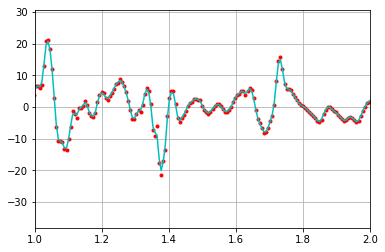

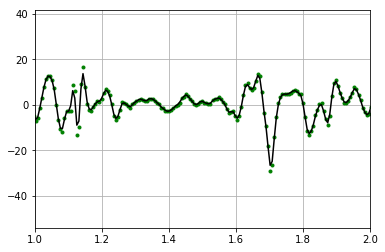

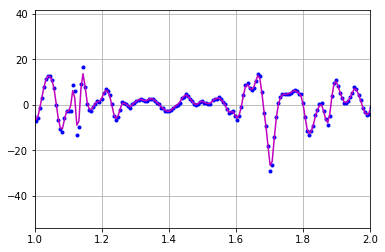

In [27]:
%%px 

if rank==0:
    pos = vx_xldx > 0
    neg = vx_xldx < 0
    scale = 30
    
    dx = 2.*np.pi/1024
    vxlgrx = np.gradient(vx_xl)/dx
    vxlgry = np.gradient(vx_yl)/dx
    vxlgrz = np.gradient(vx_zl)/dx
            
    plt.xlim((1,2))
    plt.grid()
    plt.plot(Y,vx_xldx,'r.')
    plt.plot(Y,vxlgrx,'c-')
    
    plt.show()
    
    plt.xlim((1,2))
    plt.grid()
    plt.plot(Y,vx_yldx,'g.')
    plt.plot(Y,vxlgry,'k-')
    
    plt.show()
    
    plt.xlim((1,2))
    plt.grid()
    plt.plot(Y,vx_yldx,'b.')
    plt.plot(Y,vxlgry,'m-')
    
    plt.show()

[output:6]

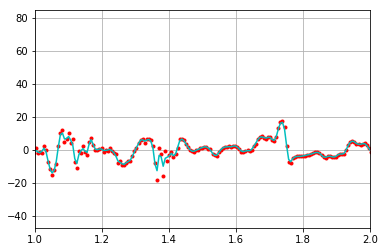

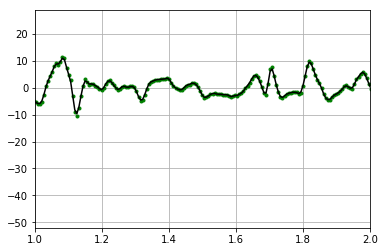

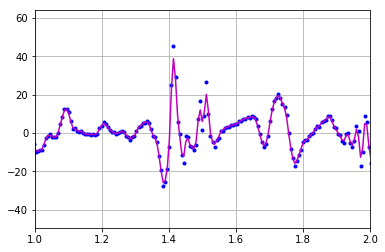

In [28]:
%%px 

if rank==0:
    pos = vx_xldx > 0
    neg = vx_xldx < 0
    scale = 30
    
    dx = 2.*np.pi/1024
    vylgrx = np.gradient(vy_xl)/dx
    vylgry = np.gradient(vy_yl)/dx
    vylgrz = np.gradient(vy_zl)/dx
            
    plt.xlim((1,2))
    plt.grid()
    plt.plot(Y,vy_xldx,'r.')
    plt.plot(Y,vylgrx,'c-')
    
    plt.show()
    
    plt.xlim((1,2))
    plt.grid()
    plt.plot(Y,vy_yldx,'g.')
    plt.plot(Y,vylgry,'k-')
    
    plt.show()
    
    plt.xlim((1,2))
    plt.grid()
    plt.plot(Y,vy_zldx,'b.')
    plt.plot(Y,vylgrz,'m-')
    
    plt.show()

In [29]:
%%px 

Q = 0.5*( (A12*A21+A23*A32+A13*A31) - (A22*A33+A11*A33+A11*A22) )

In [30]:
%%px

slabQ = np.average(Q)

avgQ=np.zeros(1,dtype=FFT.float)

comm.Reduce([slabQ,MPI.DOUBLE],[avgQ,MPI.DOUBLE],op=MPI.SUM)
avgQ = avgQ[0]/nproc
avgQ = comm.bcast(avgQ, root=0)

if rank==0:
    print("Average Q = "+str(avgQ))

[stdout:6] Average Q = 6.50521303491e-18


In [31]:
%%px

R = A11**3 + A22**3 + A33**3 + 3*( A11*(A21*A12+A13*A31) + A22*(A12*A21+A23*A32) + A33*(A13*A31+A23*A32) + A13*A21*A32 + A12*A23*A31 )

In [32]:
%%px

slabR = np.average(R)

avgR=np.zeros(1,dtype=FFT.float)

comm.Reduce([slabR,MPI.DOUBLE],[avgR,MPI.DOUBLE],op=MPI.SUM)
avgR = avgR[0]/nproc
avgR = comm.bcast(avgR, root=0)

if rank==0:
    print("Average R = "+str(avgR))

[stdout:6] Average R = -0.00386905374975


In [33]:
%%px

slabQ2 = np.average(Q**2)

avgQ2=np.zeros(1,dtype=FFT.float)

comm.Reduce([slabQ2,MPI.DOUBLE],[avgQ2,MPI.DOUBLE],op=MPI.SUM)
avgQ2 = avgQ2[0]/nproc
avgQ2 = comm.bcast(avgQ2, root=0)

if rank==0:
    print("Average Q^2 = "+str(avgQ2))

[stdout:6] Average Q^2 = 17679.1773945


In [34]:
%%px

slabR = np.average(R)

avgR=np.zeros(1,dtype=FFT.float)

comm.Reduce([slabR,MPI.DOUBLE],[avgR,MPI.DOUBLE],op=MPI.SUM)
avgR = avgR[0]/nproc
avgR = comm.bcast(avgR, root=0)

if rank==0:
    print("<R>/(<Q^2>^3/2) = "+str(avgR/(avgQ2**1.5)))

[stdout:6] <R>/(<Q^2>^3/2) = -1.64593121884e-09


In [35]:
%%px 

del Q,R

In [36]:
%%px

Omega = 0.5*( A12**2 + A21**2 + A13**2 + A31**2 + A23**2 + A32**2 - 2.*(A12*A21+A13*A31+A23*A32) )

In [37]:
%%px

slabO = np.average(Omega)

avgO=np.zeros(1,dtype=FFT.float)

comm.Reduce([slabO,MPI.DOUBLE],[avgO,MPI.DOUBLE],op=MPI.SUM)
avgO = avgO[0]/nproc
avgO = comm.bcast(avgO, root=0)

if rank==0:
    print("Average enstrophy = "+str(avgO))

[stdout:6] Average enstrophy = 249.217753644


In [38]:
%%px

Epsilon  = A11**2 + A22**2 + A33**2 
Epsilon += 0.5*( A12**2 + A21**2 + A23**2 + A32**2 + A13**2 + A31**2 )
Epsilon += A12*A21 + A13*A31 + A23*A32

In [39]:
%%px

slabE = np.average(Epsilon)

avgE=np.zeros(1,dtype=FFT.float)

comm.Reduce([slabE,MPI.DOUBLE],[avgE,MPI.DOUBLE],op=MPI.SUM)
avgE = avgE[0]/nproc
avgE = comm.bcast(avgE, root=0)

if rank==0:
    print("Average strainrate = "+str(avgE))

[stdout:6] Average strainrate = 249.217753647


In [40]:
%%px

if rank==0:
    print("Average strainrate - enstrophy: "+str(avgE-avgO))
    print("Normalized strainrate - enstrophy: "+str((avgE-avgO)/avgO))

[stdout:6] 
Average strainrate - enstrophy: 3.28691385221e-09
Normalized strainrate - enstrophy: 1.31889233578e-11


In [41]:
%%px

del Omega, Epsilon

In [42]:
%%px

eps = 2*nu*avgE

In [43]:
%%px

urms = np.sqrt(2.*avgK/3)
lamb = np.sqrt(15.*nu/eps)*urms
ReTayor = urms*lamb/nu
if rank==0:
    print("nu = "+str(nu))
    print("urms = "+str(urms)+", Reference: 0.6820399")
    print("eps = "+ str(eps))
    print("kinectic energy = "+str(avgK))
    print("Taylor micro-scale ="+str(lamb))
    print("ReLamb = "+str(ReTayor)+", Reference: 426.8378")

[stdout:6] 
nu = 0.000185
urms = 0.674645204139, Reference: 0.6820399
eps = 0.0922105688495
kinectic energy = 0.682719227202
Taylor micro-scale =0.11703522127
ReLamb = 426.795949972, Reference: 426.8378
